# Multi-Criteria Smartphone Ranking Using ELECTRE-III Method

## Project Overview  
This study presents a multi-criteria decision analysis (MCDA) framework for smartphone evaluation using the ELECTRE-III outranking method. The implementation considers three distinct preference configurations to assess how different weighting strategies impact device rankings. The analysis leverages technical specifications from contemporary smartphones across five key criteria: processing power, memory capacity, camera performance, battery capacity, and physical weight.

## Methodological Framework  

### 1. ELECTRE-III Key Formulations  
The implementation follows these essential ELECTRE-III components:

#### Credibility Matrix Calculation:  
For each alternative pair (a, b):  

$
\sigma(a,b) = \prod_{j \in F(a,b)} \frac{1 - d_j(a,b)}{1 - C(a,b)}
$

where:  
- $C(a,b)$ = Concordance index  
- $d_j(a,b)$ = Discordance index for criterion $j$
- $F(a,b)$ = Set of criteria where $d_j(a,b) > C(a,b)$

#### Net Flow Score:  

$
\phi(a) = \sum_{b \neq a} \sigma(a,b) - \sum_{b \neq a} \sigma(b,a)
$

### 2. Configuration Pipeline  
For each preference scenario, the analysis executes these sequential steps:

1. **Weighted Criteria Initialization**  
2. **Threshold Specification**  
   - Indifference (q)  
   - Preference (p)  
   - Veto (v)  
3. **Credibility Matrix Construction**  
4. **Net Flow Calculation**  
5. **Ranking Generation**

In [193]:
import pandas as pd
import numpy as np
from mcda import *
from mcda.internal.outranking.electre import Electre3
from mcda.scales import *
import matplotlib.pyplot as plt
import seaborn as sns

---

## 1. Utility Functions

This section introduces a collection of essential utility functions designed to facilitate data preparation, visualization, and result interpretation throughout the ELECTRE III decision-making process. These functions standardize data, offer visual insights into the performance and credibility matrices, and present the final ranking in an easily digestible format.

The `normalize_matrix` function, in particular, is crucial for transforming raw data into a comparable scale, which is a prerequisite for most MCDA methods. It employs a min-max scaling technique, adjusting for the optimization direction of each criterion.

The following Python code defines these utility functions:

* `normalize_matrix`: This function normalizes the input decision matrix. For maximization criteria, the normalization formula is:
    $$x' = \frac{x - x_{min}}{x_{max} - x_{min}}$$
For minimization criteria, the formula is:
    $$x' = \frac{x_{max} - x}{x_{max} - x_{min}}$$

It handles cases where the range of values for a criterion is zero by assigning a neutral value of 0.5.

* `plot_performance_matrix`: This function visualizes the normalized performance matrix as a heatmap, allowing for a clear understanding of each alternative's performance across all criteria.

* `plot_credibility_matrix`: This function generates a heatmap of the credibility matrix, illustrating the degree of outranking between each pair of alternatives as computed by ELECTRE III.

* `plot_net_flow_scores`: This function displays the net flow scores, which are derived from the credibility matrix and are instrumental in determining the final ranking.

* `plot_ranking_bars`: This function provides a visual representation of the final ranking of alternatives in a bar chart format.

In [194]:
def normalize_matrix(matrix, directions):
    """
    Normalize decision matrix using min-max scaling with directional preference
    
    Args:
        matrix: Input matrix of shape (n_alternatives, n_criteria)
        directions: List of optimization directions ('max'/'min') for each criterion
        
    Returns:
        ndarray: Normalized matrix with values in [0,1]
    
    Implements:
        For max-direction criteria: 
            $$ x' = \frac{x - x_{min}}{x_{max} - x_{min}} $$
        For min-direction criteria:
            $$ x' = \frac{x_{max} - x}{x_{max} - x_{min}} $$
    Handles constant columns by assigning neutral 0.5 values
    """
    
    matrix = matrix.astype(np.float64)
    normalized = np.zeros_like(matrix)
    
    
    if len(directions) != matrix.shape[1]:
        raise ValueError("Directions list must match number of criteria columns")
    
    for i in range(matrix.shape[1]):
        col = matrix[:, i]
        min_val = np.min(col)
        max_val = np.max(col)
        range_val = max_val - min_val
        
        
        if range_val == 0:
            normalized[:, i] = 0.5
            continue
            
        if directions[i] == 'max':
            normalized[:, i] = (col - min_val) / range_val
        else:
            normalized[:, i] = (max_val - col) / range_val
            
    return normalized

def plot_performance_matrix(raw_matrix):
    """
    Visualize normalized performance matrix with annotated raw values
    
    Parameters:
        raw_matrix: Original decision matrix containing criterion values
    
    Produces:
        Heatmap visualization with criteria on x-axis and alternatives on y-axis
        Gray separator lines between axes
    """
    
    directions = ['max', 'max', 'max', 'max', 'min']
    norm_matrix = normalize_matrix(raw_matrix, directions)
    
    norm_df = pd.DataFrame(
        norm_matrix,
        columns=df.columns[1:],
        index=alternatives
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        norm_df,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        annot_kws={"size": 9}
    )
    
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.xlabel("Criterias", fontsize=12)
    plt.ylabel("Smartphones", fontsize=12)
    plt.title("Normalized Performance Matrix (0-1)", pad=20, fontsize=14)
    
    plt.gca().axhline(0, color='black', linewidth=1.5)
    plt.gca().axvline(0, color='black', linewidth=1.5)
    
    plt.tight_layout()
    plt.show()
    
def plot_credibility_matrix(ranking):
    """
    Visualize ELECTRE-III credibility matrix
    
    Args:
        ranking (AdjacencyValueMatrix): Outranking relationships matrix from Electre3.rank()
    
    Displays:
        Blue-scale heatmap with alternative comparisons
        45° rotated x-axis labels for readability
    """
    
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(
        ranking.data, 
        annot=True, 
        xticklabels=ranking.vertices, 
        yticklabels=ranking.vertices,
        cmap="Blues",
        fmt=".0f",
        cbar=False
    )
    
    plt.title("Credibility Matrix (0 = no outranking, 1 = certain outranking)", pad=20)
    ax.set_xlabel("Alternative", labelpad=15)
    ax.set_ylabel("Alternative", labelpad=15)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
def plot_net_flow_scores(scores):
    """
    Visualize net flow scores determining final ranking
    
    Args:
        scores (pd.Series): Calculated net flows from credibility matrix
        
    Produces:
        Horizontal bar chart sorted by score magnitude
    """
    
    plt.figure(figsize=(10, 6))
    scores.sort_values().plot(kind='barh', color='#1f77b4')
    plt.title("Net Flow Scores")
    plt.xlabel("Score")
    plt.grid(axis='x')
    plt.show()
    
def plot_ranking_bars(ranking):
    """
    Generate horizontal bar chart of final ranking
    
    Args:
        ranking (list): Ordered list of alternatives from best to worst
    
    Displays:
        Positional ranking with best alternative at top
        Gridlines for visual reference
    """
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(ranking)), [len(ranking)-i for i in range(len(ranking))], tick_label=ranking)
    plt.title("Smartphones Ranking")
    plt.xlabel("Position")
    plt.grid(axis='x', linestyle='--')
    plt.show()

---

## 2. Dataset Definition and Criteria Scales

This section focuses on loading the raw performance data for the alternatives and defining the **scales for each criterion**. The ELECTRE III method requires a clear understanding of the range and preference direction for each criterion to properly evaluate outranking relationships.

The raw data, typically stored in a CSV file, contains the performance values of each alternative across various criteria. These values are then extracted to form the decision matrix. For each criterion, a `QuantitativeScale` is defined, specifying its minimum and maximum possible values, along with the **preference direction** (whether a higher value is preferred, i.e., 'max', or a lower value is preferred, i.e., 'min'). This information is crucial for the subsequent normalization and comparison steps within the ELECTRE III framework.

The following code loads the smartphone data, extracts alternatives and the raw performance matrix, and defines the quantitative scales for each criterion. Finally, it visualizes the normalized performance matrix to provide an initial overview of the data distribution.

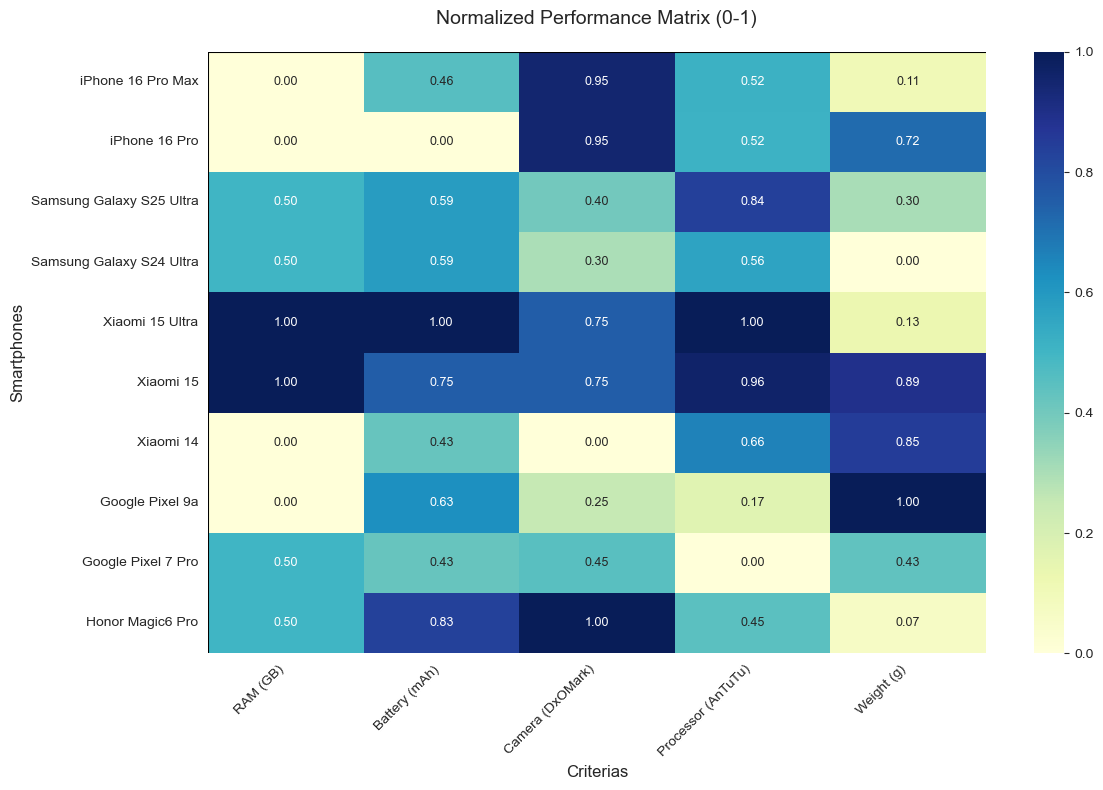

In [195]:
# Load raw data
df = pd.read_csv("../data/smartphones_raw.csv")
alternatives = df['Smartphone'].tolist()
raw_matrix = df.drop(columns='Smartphone').values

# Define RAW scales based on data
scales = {
    'RAM (GB)': QuantitativeScale(8, 16, preference_direction=MAX),
    'Battery (mAh)': QuantitativeScale(3582, 6000, preference_direction=MAX),
    'Camera (DxOMark)': QuantitativeScale(138, 158, preference_direction=MAX),
    'Processor (AnTuTu)': QuantitativeScale(847016, 2459958, preference_direction=MAX),
    'Weight (g)': QuantitativeScale(186, 232, preference_direction=MIN)
}

# Plot the normalized performance matrix
plot_performance_matrix(raw_matrix)

-----

## 3. ELECTRE III Application: Balanced Criteria Configuration

This section initiates the application of the ELECTRE III method with a **balanced criteria weighting scheme**. In ELECTRE III, defining the weights of each criterion is crucial as it reflects their relative importance in the decision-making process. This configuration also involves setting the indifference ($q$), preference ($p$), and veto ($v$) thresholds, which are fundamental to establishing the outranking relationships between alternatives.

### 3.1. Configuration of Criteria Weights, Indifference, Preference, and Veto Thresholds

The following code block defines the **weights for each criterion**, ensuring they sum to 1, indicating a balanced distribution of importance. It also sets up the `PerformanceTable` object, which encapsulates the raw data, alternatives, criteria, and their respective scales. Following this, the specific values for the indifference ($q$), preference ($p$), and veto ($v$) thresholds are defined for each criterion. These thresholds play a critical role in the calculation of concordance and discordance, ultimately determining the credibility of outranking statements.

* **Criterion Weights (`balanced_criteria`)**: These values represent the relative importance assigned to each criterion. Where $w\_j$ is the weight of criterion $j$.
$$\sum_{j=1}^{n} w_j = 1$$

* **Indifference Threshold ($q$)**: For a given criterion, if the difference between two alternatives' performances is less than or equal to $q$, they are considered indifferent.
$$|g_j(a) - g_j(b)| \le q_j$$

* **Preference Threshold ($p$)**: If the difference in performance is greater than $q$ but less than or equal to $p$, one alternative is weakly preferred over the other.
$$q_j < |g_j(a) - g_j(b)| \le p_j$$

* **Veto Threshold ($v$)**: If the difference in performance exceeds $v$, the preference for one alternative over another is so strong that it can potentially block an outranking relationship, even if other criteria support it.
$$|g_j(a) - g_j(b)| > v_j$$

In [196]:
# Define balanced weights for each criterion
balanced_criteria = {
    'RAM (GB)': 0.15,
    'Battery (mAh)': 0.25,
    'Camera (DxOMark)': 0.25,
    'Processor (AnTuTu)': 0.25,
    'Weight (g)': 0.10
}

# Create a PerformanceTable object with the raw data, alternatives, criteria, and scales
balanced_pt = PerformanceTable(
    raw_matrix,
    alternatives = alternatives,
    criteria = balanced_criteria,
    scales = scales
)

# Define indifference thresholds (q) for each criterion
balanced_q = {
    'RAM (GB)': 2,
    'Battery (mAh)': 251,
    'Camera (DxOMark)': 2,
    'Processor (AnTuTu)': 200000,
    'Weight (g)': 5
}

# Define preference thresholds (p) for each criterion
balanced_p = {
    'RAM (GB)': 4,
    'Battery (mAh)': 502,
    'Camera (DxOMark)': 6,
    'Processor (AnTuTu)': 380000,
    'Weight (g)': 15
}

# Define veto thresholds (v) for each criterion
balanced_v = {
    'RAM (GB)': 4,
    'Battery (mAh)': 502,
    'Camera (DxOMark)': 12,
    'Processor (AnTuTu)': 700000,
    'Weight (g)': 30
}

-----

### 3.2. Credibility Matrix Calculation and Visualization (Balanced Criteria)

Having defined the criteria weights and thresholds, the next step in the ELECTRE III methodology is to compute the **credibility matrix**. This matrix quantifies the strength of the outranking relationship between every pair of alternatives, considering all criteria and their associated thresholds. The credibility index $\\sigma(a,b)$ for an outranking assertion "$a$ outranks $b$" is a value between 0 and 1, representing the degree of truth of this assertion. It is derived from the concordance and discordance indices.

The concordance index $C(a,b)$ reflects the extent to which $a$ is preferred to $b$ based on the criteria weights and preference/indifference thresholds. The discordance index $D_j(a,b)$ measures the degree to which criterion $j$ opposes the assertion that $a$ outranks $b$, typically using the veto threshold.

The credibility index $\\sigma(a,b)$ is generally calculated as:
$$\sigma(a,b) = C(a,b) \times \prod_{j \in J_D} \left( \frac{v_j - (g_j(b) - g_j(a))}{v_j - p_j} \right)$$
where $J_D$ is the set of discordant criteria, and the product term applies only if $g_j(b) - g_j(a) > p_j$. If $g_j(b) - g_j(a) > v_j$ for any $j$, then $\\sigma(a,b) = 0$.

The `Electre3` object is instantiated with the previously defined parameters. The `rank()` method then performs the necessary calculations to build the outranking relationships, including the credibility matrix. The resulting credibility matrix is then visualized as a heatmap, providing a clear representation of the outranking degrees between alternatives under this balanced criteria configuration.

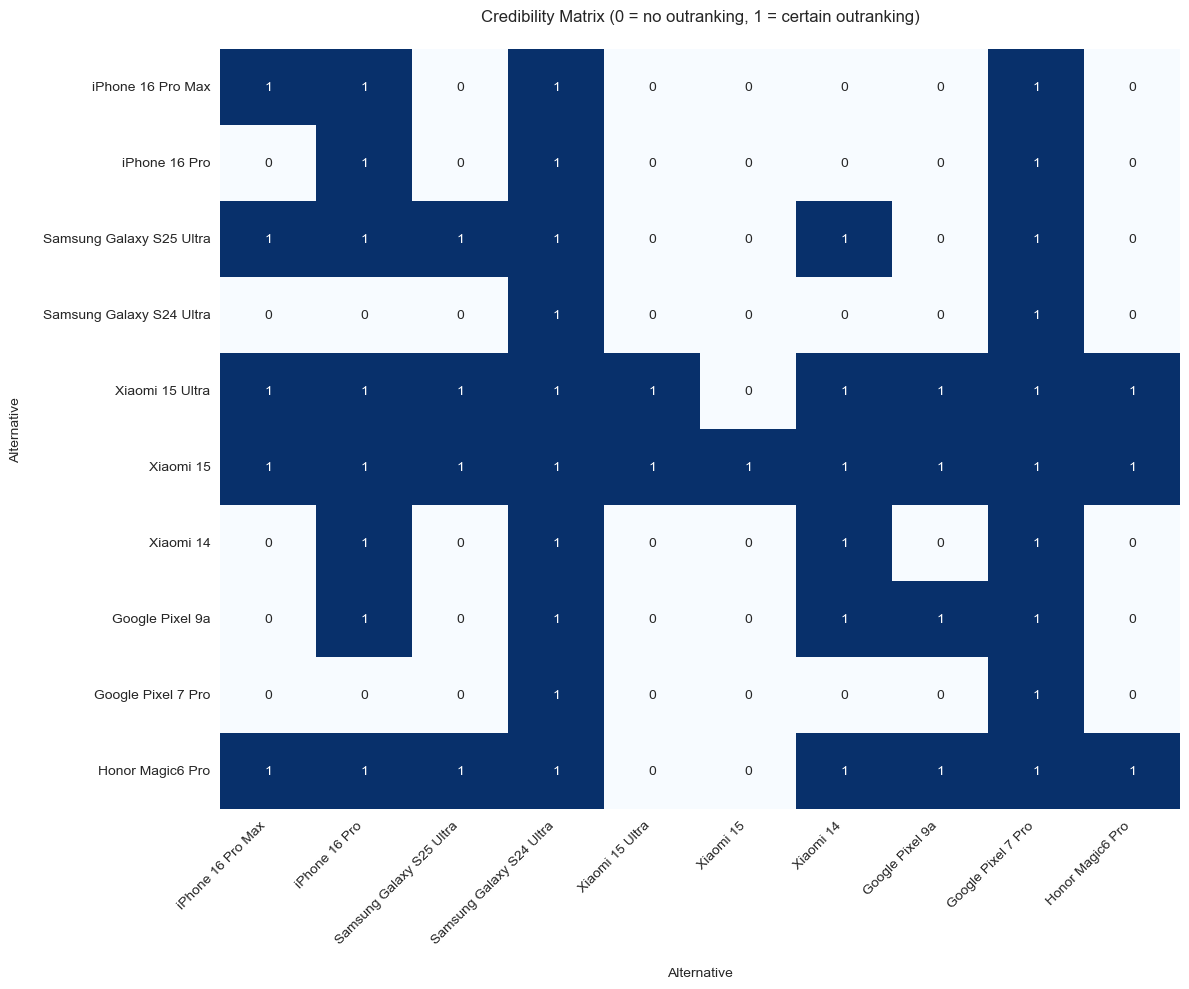

In [197]:
# Initialize Electre3 model with the balanced criteria configuration
electre3 = Electre3(
    performance_table = balanced_pt,
    criteria_weights = balanced_criteria,
    preference_thresholds = balanced_p,
    indifference_thresholds = balanced_q,
    veto_thresholds = balanced_v,
    alpha = 0.3,  # Discrimination threshold for weak outranking
    beta = -0.15  # Discrimination threshold for strong outranking
)

# Calculate the outranking relationships and obtain the ranking results
balanced_rank = electre3.rank()

# Visualize the credibility matrix for the balanced criteria
plot_credibility_matrix(balanced_rank)

-----

### 3.3. Net Flow Scores and Final Ranking (Balanced Criteria)

The credibility matrix, while showing pairwise outranking relationships, doesn't directly provide a complete ranking of all alternatives. To achieve a comprehensive ranking, **net flow scores** are calculated. These scores summarize the overall outranking performance of each alternative by considering both the strength of its outranking other alternatives (positive flow) and the strength with which it is outranked by others (negative flow).

The net flow score for an alternative $a$ is computed as the difference between its outranking flow (leaving flow) and its outranked flow (entering flow):
$$\text{Net Flow}(a) = \sum_{b \in A, b \neq a} \sigma(a,b) - \sum_{b \in A, b \neq a} \sigma(b,a)$$
A higher net flow score indicates a stronger overall preference for that alternative, leading to a better position in the final ranking.

The code below calculates these net flow scores from the `balanced_rank` credibility matrix. The scores are then visualized using a horizontal bar chart, which clearly illustrates the relative performance of each smartphone under the balanced criteria configuration and directly provides the final ranking.

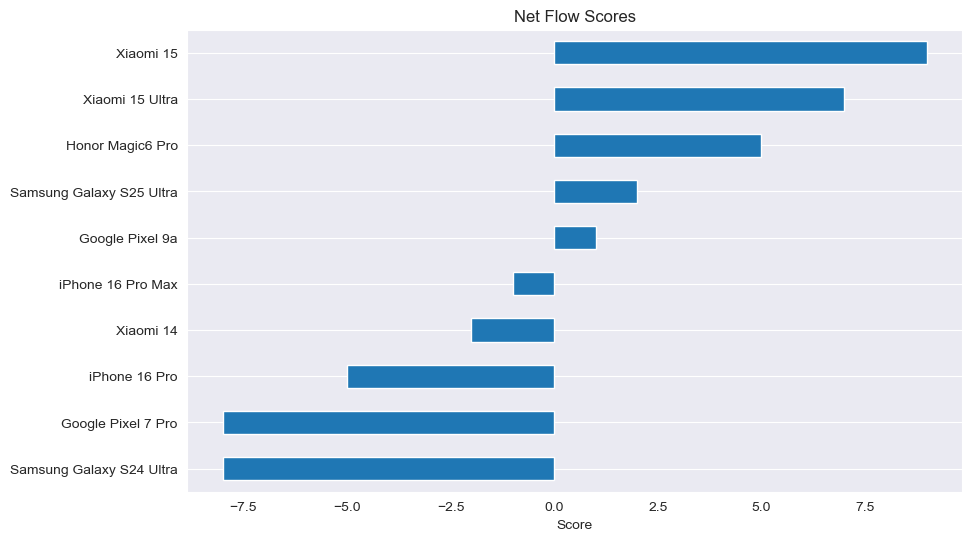

In [198]:
# Calculate net flow scores
# Sum of each row (outranking flow) minus sum of each column (outranked flow)
balanced_scores = balanced_rank.data.sum(axis=1) - balanced_rank.data.sum(axis=0)

# Plot the net flow scores to visualize the final ranking
plot_net_flow_scores(balanced_scores)

-----

### 3.4. Final Ranking Visualization (Balanced Criteria)

Following the calculation of net flow scores, the final step for this particular criteria configuration is to establish and visualize the definitive ranking of alternatives. The net flow scores provide a clear numerical basis for ordering the alternatives, with higher scores indicating a more preferred option.

The code below sorts the alternatives based on their calculated net flow scores in ascending order, effectively determining the final rank from worst to best. This ordered list is then passed to a visualization function that generates a horizontal bar chart, presenting the final ranking in an intuitive and easy-to-understand format. This concludes the analysis for the balanced criteria configuration, providing a clear outcome based on the specified weights and thresholds.

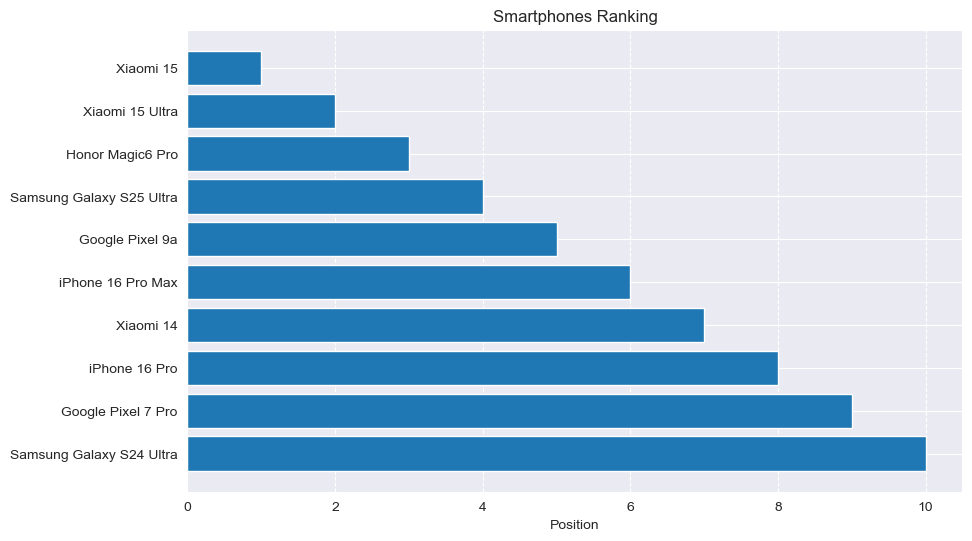

In [199]:
# Sort alternatives based on net flow scores to obtain the final ranking
balanced_ranking = balanced_scores.sort_values(ascending=True).index.tolist()

# Plot the final ranking as a bar chart
plot_ranking_bars(balanced_ranking)

-----

## 4. ELECTRE III Application: Performance-Oriented Criteria Configuration

This section introduces a second application of the ELECTRE III method, this time with a **performance-oriented criteria weighting scheme**. This configuration specifically emphasizes the "Processor (AnTuTu)" and "RAM (GB)" criteria, allocating significantly higher weights to them. Conversely, "Battery (mAh)" and "Camera (DxOMark)" receive lower weights, and "Weight (g)" is entirely excluded (weight of 0), indicating it is not a factor in this specific decision-making scenario.

### 4.1. Configuration of Criteria Weights, Indifference, Preference, and Veto Thresholds (Performance-Oriented)

This code block defines the new set of **criteria weights**, reflecting a strategic shift towards prioritizing computational performance. The `PerformanceTable` is re-initialized with these new weights. Furthermore, specific indifference ($q$), preference ($p$), and veto ($v$) thresholds are set for each criterion. These thresholds are tailored to the performance-oriented focus, potentially reflecting different sensitivities to performance differences compared to the balanced approach. For instance, the veto threshold for "Processor (AnTuTu)" might be set to more aggressively penalize alternatives with significantly lower performance.

  * **Criterion Weights (`performance_criteria`)**: Notice the pronounced increase in weight for 'Processor (AnTuTu)' and 'RAM (GB)', and the complete exclusion of 'Weight (g)'.
  * **Indifference Threshold ($q$)**: These thresholds define the range within which performance differences are considered negligible.
  * **Preference Threshold ($p$)**: These thresholds indicate a noticeable preference for one alternative over another.
  * **Veto Threshold ($v$)**: These thresholds specify a critical difference in performance that can completely override an outranking relationship, even if other criteria support it. The values here are likely adjusted to align with the performance focus.

In [200]:
# Define weights for a performance-oriented criteria configuration
performance_criteria = {
    'RAM (GB)': 0.20,
    'Battery (mAh)': 0.05,
    'Camera (DxOMark)': 0.05,
    'Processor (AnTuTu)': 0.70, # Significantly higher weight for processor
    'Weight (g)': 0.0          # Weight excluded
}

# Create a PerformanceTable object with the raw data, alternatives, new criteria weights, and scales
performance_pt = PerformanceTable(
    raw_matrix,
    alternatives = alternatives,
    criteria = performance_criteria,
    scales = scales
)

# Define indifference thresholds (q) for the performance-oriented criteria
performance_q = {
    'RAM (GB)': 1,
    'Battery (mAh)': 100,
    'Camera (DxOMark)': 1,
    'Processor (AnTuTu)': 50000, # Potentially lower q for processor to distinguish better
    'Weight (g)': 15
}

# Define preference thresholds (p) for the performance-oriented criteria
performance_p = {
    'RAM (GB)': 2,
    'Battery (mAh)': 400,
    'Camera (DxOMark)': 2,
    'Processor (AnTuTu)': 200000, # Higher p for processor, allowing for more distinct preferences
    'Weight (g)': 46
}

# Define veto thresholds (v) for the performance-oriented criteria
performance_v = {
    'RAM (GB)': 5,
    'Battery (mAh)': 700,
    'Camera (DxOMark)': 4,
    'Processor (AnTuTu)': 400000, # Higher v for processor, emphasizing strong performance differences
    'Weight (g)': 46
}

-----

### 4.2. Credibility Matrix Calculation and Visualization (Performance-Oriented Criteria)

With the performance-oriented criteria weights and thresholds in place, the ELECTRE III model is now applied to compute the **credibility matrix** for this new scenario. The credibility matrix reflects the degree to which one alternative outranks another, taking into account the heightened importance of processing power and RAM, and the specific sensitivities defined by the new indifference, preference, and veto thresholds.

The `Electre3` object is initialized with the `performance_pt` (which includes the performance-oriented criteria weights) and the corresponding `performance_p`, `performance_q`, and `performance_v` thresholds. The `rank()` method then performs the comprehensive pairwise comparisons, synthesizing the concordance and discordance information to generate the credibility indices. The resulting matrix is subsequently visualized, providing a visual representation of how outranking relationships are shaped when computational performance is highly prioritized.

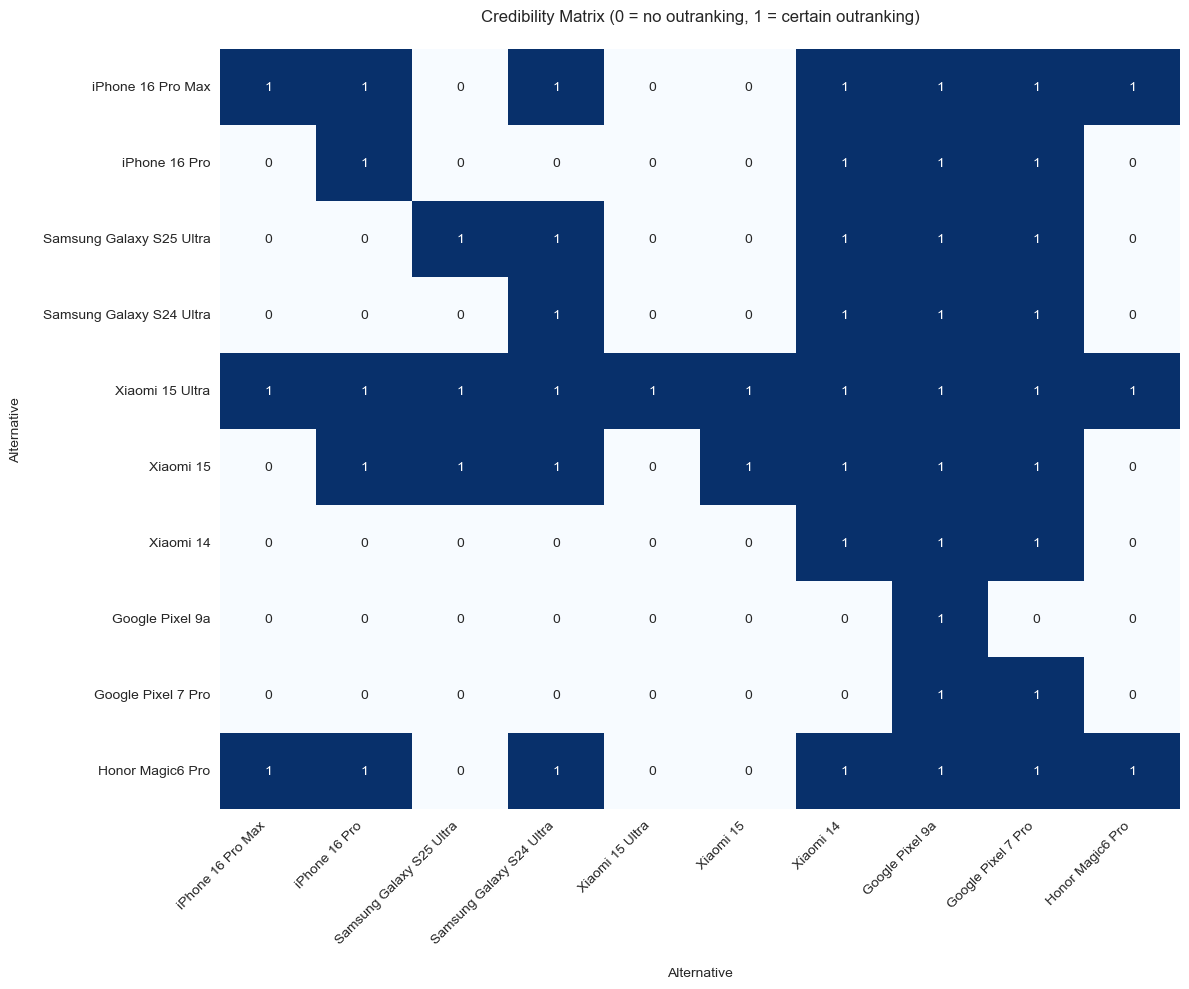

In [201]:
# Initialize Electre3 model with the performance-oriented criteria configuration
electre3 = Electre3(
    performance_table = performance_pt,
    criteria_weights = performance_criteria,
    preference_thresholds = performance_p,
    indifference_thresholds = performance_q,
    veto_thresholds = performance_v,
    alpha = 0.3,  # Discrimination threshold for weak outranking
    beta = -0.15  # Discrimination threshold for strong outranking
)

# Calculate the outranking relationships and obtain the ranking results
performance_rank = electre3.rank()

# Visualize the credibility matrix for the performance-oriented criteria
plot_credibility_matrix(performance_rank)

-----

### 4.3. Net Flow Scores and Final Ranking (Performance-Oriented Criteria)

With the credibility matrix computed under the performance-oriented configuration, the next logical step is to derive a consolidated ranking through the calculation of **net flow scores**. These scores provide a comprehensive summary of each alternative's overall outranking performance, reflecting how well it outranks other alternatives versus how much it is outranked by them, all under the specific emphasis on processing power and RAM.

The net flow score for an alternative $a$ is determined by subtracting its entering flow (the sum of credibility indices where $a$ is outranked) from its leaving flow (the sum of credibility indices where $a$ outranks other alternatives). A higher net flow score indicates a stronger overall preference for that alternative within this performance-focused evaluation.

The following code calculates these net flow scores from the `performance_rank` credibility matrix. Subsequently, a horizontal bar chart visualizes these scores, offering a clear and immediate understanding of the final ranking of alternatives when computational performance criteria are prioritized.

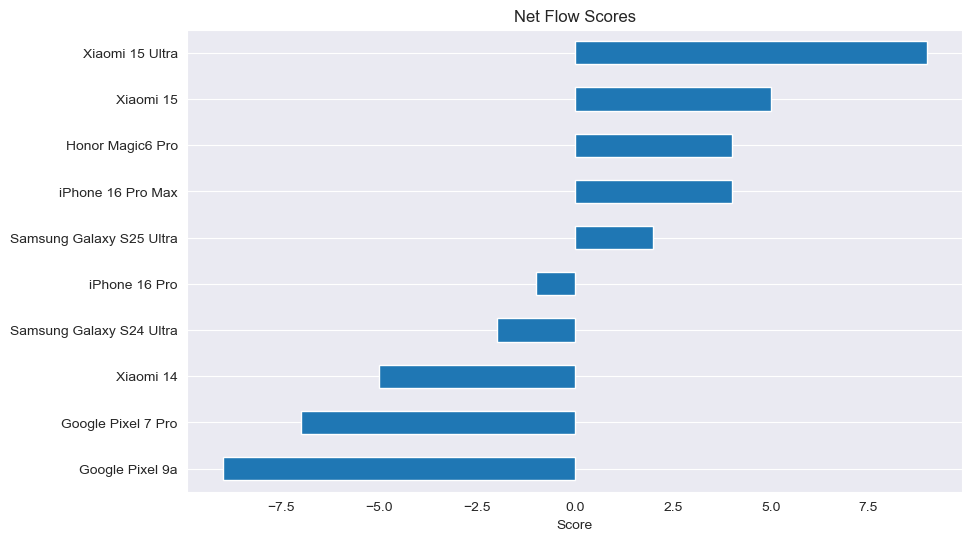

In [202]:
# Calculate net flow scores for the performance-oriented ranking
# Sum of each row (outranking flow) minus sum of each column (outranked flow)
performance_scores = performance_rank.data.sum(axis=1) - performance_rank.data.sum(axis=0)

# Plot the net flow scores to visualize the final ranking
plot_net_flow_scores(performance_scores)

-----

### 4.4. Final Ranking Visualization (Performance-Oriented Criteria)

With the net flow scores calculated for the performance-oriented configuration, the conclusive step is to establish and present the final ranking of alternatives. The net flow scores directly dictate the order, with higher scores indicating a more favorable position based on the prioritized performance criteria.

The code below sorts the alternatives according to their calculated net flow scores in ascending order, thereby determining the final rank from the least preferred to the most preferred. This ordered list is then utilized by a visualization function to generate a horizontal bar chart, offering a clear and intuitive representation of the smartphones' ranking when processing power and RAM are given utmost importance. This visualization effectively summarizes the outcome of the ELECTRE III analysis under this specific performance-focused scenario.

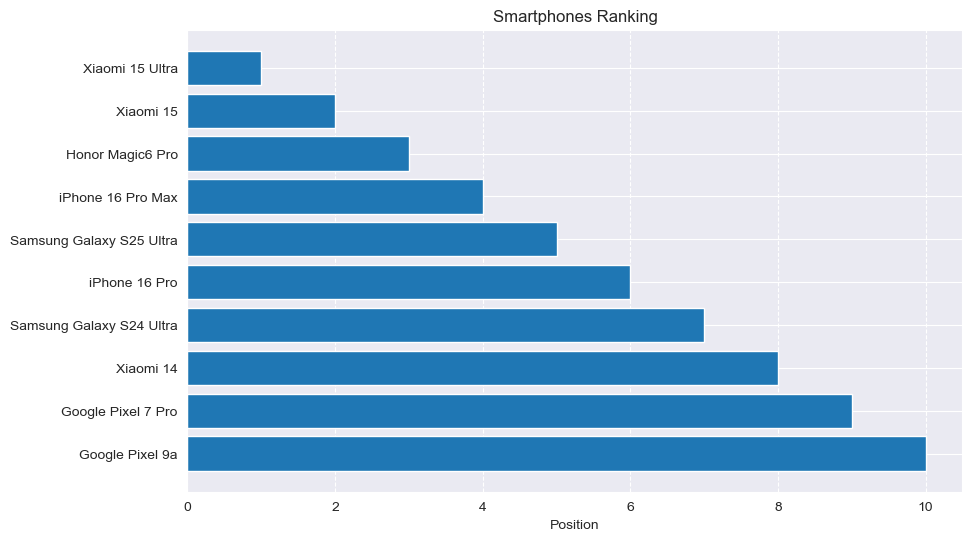

In [203]:
# Sort alternatives based on net flow scores to obtain the final ranking for the performance-oriented case
performance_ranking = performance_scores.sort_values(ascending=True).index.tolist()

# Plot the final ranking as a bar chart
plot_ranking_bars(performance_ranking)

-----

### 5\. ELECTRE III Application: Lightweight-Oriented Criteria Configuration

This section presents the final application of the ELECTRE III method, focusing on a **lightweight-oriented criteria weighting scheme**. In this configuration, the primary emphasis is placed on "Weight (g)," assigning it a significantly high weight. Conversely, "RAM (GB)" and "Processor (AnTuTu)" are entirely excluded (weight of 0), indicating that these computational aspects are not considered relevant in this specific decision-making context. "Battery (mAh)" and "Camera (DxOMark)" receive minimal importance.

#### 5.1. Configuration of Criteria Weights, Indifference, Preference, and Veto Thresholds (Lightweight-Oriented)

This code block defines the new set of **criteria weights**, reflecting a strong preference for lighter devices. The `PerformanceTable` is re-initialized to incorporate these new weights. Crucially, the indifference ($q$), preference ($p$), and veto ($v$) thresholds are set specifically for this lightweight focus. For criteria with zero weight, their thresholds are also set to zero, as they will not influence the outranking relationships. For "Weight (g)," the thresholds are tailored to define what constitutes an indifferent, preferred, or significantly undesirable difference in weight.

  * **Criterion Weights (`lightweight_criteria`)**: Observe the dominant weight given to 'Weight (g)', while 'RAM (GB)' and 'Processor (AnTuTu)' are assigned zero weight, effectively removing them from consideration.
  * **Indifference Threshold ($q$)**: For 'Weight (g)', this threshold defines the maximum weight difference where two alternatives are considered equally light.
  * **Preference Threshold ($p$)**: For 'Weight (g)', this threshold indicates a noticeable preference for a lighter alternative.
  * **Veto Threshold ($v$)**: For 'Weight (g)', this threshold specifies a critical weight difference that can cause one alternative to veto the outranking of another, even if other criteria (if any with non-zero weight) might suggest otherwise.

In [204]:
# Define weights for a lightweight-oriented criteria configuration
lightweight_criteria = {
    'RAM (GB)': 0.0,            # Excluded
    'Battery (mAh)': 0.1,
    'Camera (DxOMark)': 0.1,
    'Processor (AnTuTu)': 0.0,  # Excluded
    'Weight (g)': 0.8           # Significantly higher weight for weight
}

# Create a PerformanceTable object with the raw data, alternatives, new criteria weights, and scales
lightweight_pt = PerformanceTable(
    raw_matrix,
    alternatives = alternatives,
    criteria = lightweight_criteria,
    scales = scales
)

# Define indifference thresholds (q) for the lightweight-oriented criteria
lightweight_q = {
    'RAM (GB)': 0,
    'Battery (mAh)': 0,
    'Camera (DxOMark)': 0,
    'Processor (AnTuTu)': 0,
    'Weight (g)': 5  # Indifference threshold for weight
}

# Define preference thresholds (p) for the lightweight-oriented criteria
lightweight_p = {
    'RAM (GB)': 0,
    'Battery (mAh)': 0,
    'Camera (DxOMark)': 0,
    'Processor (AnTuTu)': 0,
    'Weight (g)': 15 # Preference threshold for weight
}

# Define veto thresholds (v) for the lightweight-oriented criteria
lightweight_v = {
    'RAM (GB)': 0,
    'Battery (mAh)': 0,
    'Camera (DxOMark)': 0,
    'Processor (AnTuTu)': 0,
    'Weight (g)': 20 # Veto threshold for weight
}

-----

### 5.2. Credibility Matrix Calculation and Visualization (Lightweight-Oriented Criteria)

With the lightweight-oriented criteria weights and thresholds configured, the ELECTRE III model is now applied to calculate the **credibility matrix** for this specific scenario. This matrix will reveal the degree to which one alternative outranks another, with a strong bias towards lighter devices, and taking into account the defined thresholds for weight differences.

The `Electre3` object is initialized using the `lightweight_pt` (which incorporates the lightweight-focused criteria weights) and the corresponding `lightweight_p`, `lightweight_q`, and `lightweight_v` thresholds. The `rank()` method then performs the necessary pairwise comparisons, synthesizing concordance and discordance information to generate the credibility indices. The resulting matrix is then visualized as a heatmap, offering a visual representation of how outranking relationships are established when minimizing weight is the predominant factor.

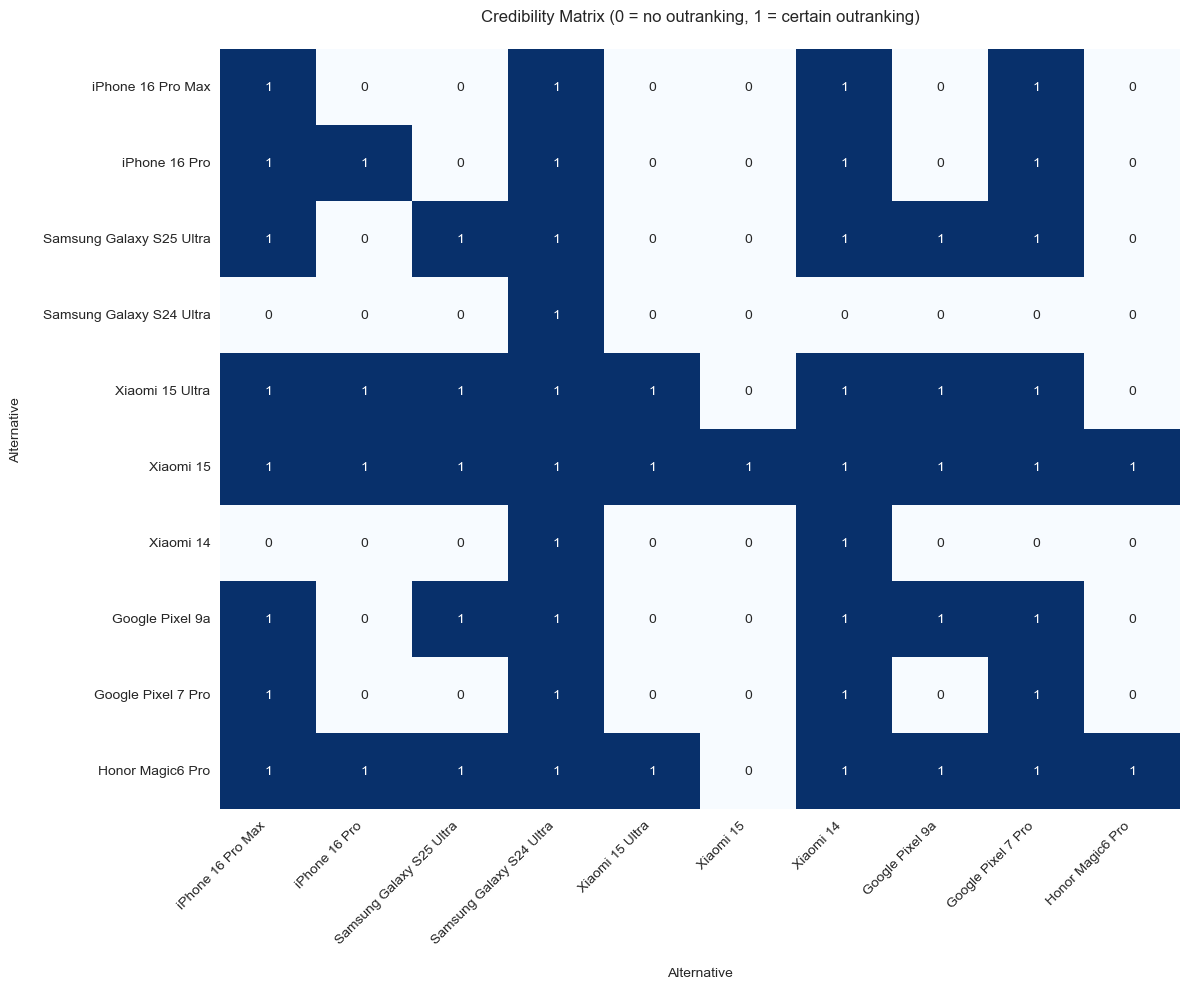

In [205]:
# Initialize Electre3 model with the lightweight-oriented criteria configuration
electre3 = Electre3(
    performance_table = lightweight_pt,
    criteria_weights = lightweight_criteria,
    preference_thresholds = lightweight_p,
    indifference_thresholds = lightweight_q,
    veto_thresholds = lightweight_v,
    alpha = 0.3,  # Discrimination threshold for weak outranking
    beta = -0.15  # Discrimination threshold for strong outranking
)

# Calculate the outranking relationships and obtain the ranking results
lightweight_rank = electre3.rank()

# Visualize the credibility matrix for the lightweight-oriented criteria
plot_credibility_matrix(lightweight_rank)

-----

### 5.3. Net Flow Scores and Final Ranking (Lightweight-Oriented Criteria)

With the credibility matrix computed under the lightweight-oriented configuration, the subsequent step involves calculating **net flow scores** to derive a consolidated ranking. These scores provide a comprehensive summary of each alternative's overall outranking performance, reflecting the balance between how well it outranks other alternatives and how much it is outranked by them, all while prioritizing the criterion of weight.

The net flow score for an alternative $a$ is derived by subtracting its entering flow (the sum of credibility indices where $a$ is outranked) from its leaving flow (the sum of credibility indices where $a$ outranks other alternatives). A higher net flow score indicates a stronger overall preference for that alternative within this lightweight-focused evaluation.

The following code calculates these net flow scores from the `lightweight_rank` credibility matrix. Subsequently, a horizontal bar chart visualizes these scores, offering a clear and immediate understanding of the final ranking of alternatives when minimizing weight is the primary concern.

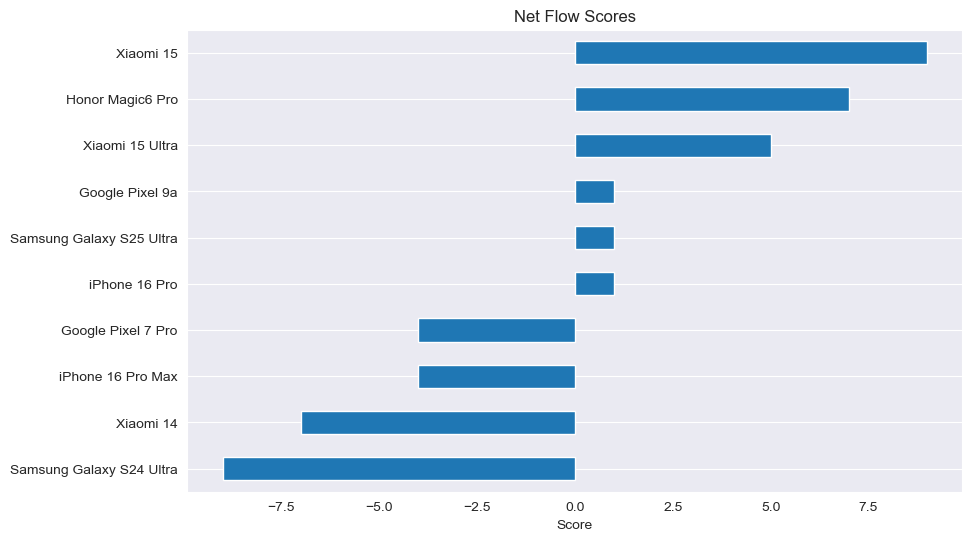

In [206]:
# Calculate net flow scores for the lightweight-oriented ranking
# Sum of each row (outranking flow) minus sum of each column (outranked flow)
lightweight_scores = lightweight_rank.data.sum(axis=1) - lightweight_rank.data.sum(axis=0)

# Plot the net flow scores to visualize the final ranking
plot_net_flow_scores(lightweight_scores)

-----

### 5.4. Final Ranking Visualization (Lightweight-Oriented Criteria)

With the net flow scores calculated for the lightweight-oriented configuration, the final step is to establish and visualize the conclusive ranking of alternatives. These net flow scores directly inform the order, with higher scores signifying a more preferred position based on the strong emphasis on minimizing device weight.

The code below sorts the alternatives according to their computed net flow scores in ascending order, thereby determining the final rank from the heaviest (least preferred) to the lightest (most preferred). This ordered list is then passed to a visualization function, which generates a horizontal bar chart. This chart provides a clear and intuitive representation of the smartphones' ranking when minimizing weight is the paramount consideration, effectively summarizing the outcome of the ELECTRE III analysis under this specific lightweight-focused scenario.

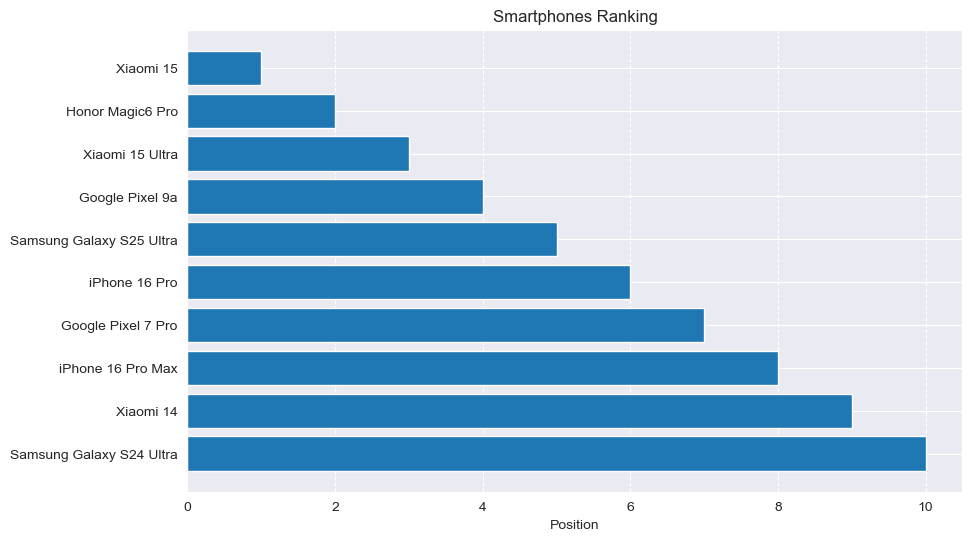

In [207]:
# Sort alternatives based on net flow scores to obtain the final ranking for the lightweight-oriented case
lightweight_ranking = lightweight_scores.sort_values(ascending=True).index.tolist()

# Plot the final ranking as a bar chart
plot_ranking_bars(lightweight_ranking)